title: HNSCC_VisiumST_Preprocessing \
author: Emilia Puig Lombardi \
date: 2024-02-01

In [ ]:
#Environment setup
library(Seurat) #4.3.0 for compatibility
library(ggplot2)
library(dplyr)
library(scater)
library(tibble)
library(SingleCellExperiment)
library(hdf5r) 
library(patchwork)
library(gtools)
library(clustree)
library(gridExtra)
library(tidyr)
library(magrittr)
library(STutility)

In [2]:
wd <- "~/ST_PP_manuscript/"
datadir = "~/ST_PP_manuscript/"
datadir1 = paste0(datadir,"19h1257-1_PP_v2/")
outputdir <- paste0(datadir,"19h1257-1_PP_v2_out")
dir.create(outputdir)

In [5]:
# Pre-treatment with STU - manual spot removal
# infoTable.txt is a tab-separated txt file with sample (h5) name and path, spots file name and path,
# high-res image name and path and scale factors json name and path
infoTable <- read.table("infoTable.txt",sep="\t",h=T)
infoTable

Warning message in read.table("infoTable.txt", sep = "\t", h = T):
“incomplete final line found by readTableHeader on 'infoTable.txt'”


samples                                      
1 19h1257-1_v3/filtered_feature_bc_matrix.h5   
2 19h1257-1_PP_v2/filtered_feature_bc_matrix.h5
  spotfiles                                   
1 19h1257-1_v3/spatial/tissue_positions.csv   
2 19h1257-1_PP_v2/spatial/tissue_positions.csv
  imgs                                          
1 19h1257-1_v3/spatial/tissue_hires_image.png   
2 19h1257-1_PP_v2/spatial/tissue_hires_image.png
  json                                          
1 19h1257-1_v3/spatial/scalefactors_json.json   
2 19h1257-1_PP_v2/spatial/scalefactors_json.json

In [6]:
obj <- InputFromTable(infoTable[2,], platform =  "Visium", disable.subset = FALSE)

Using spotfiles to remove spots outside of tissue
Loading 19h1257-1_PP_v2/filtered_feature_bc_matrix.h5 count matrix from a 'Visium' experiment

------------- Filtering (not including images based filtering) -------------- 
  Spots removed:  0  
  Genes removed:  26  
Saving capture area ranges to Staffli object 
After filtering the dimensions of the experiment is: [18059 genes, 2240 spots] 


Loading images for 1 samples: 
  Reading 19h1257-1_PP_v2/spatial/tissue_hires_image.png for sample 1 ... 
  Scaling down sample 1 image from 2000x2000 pixels to 400x400 pixels 


Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



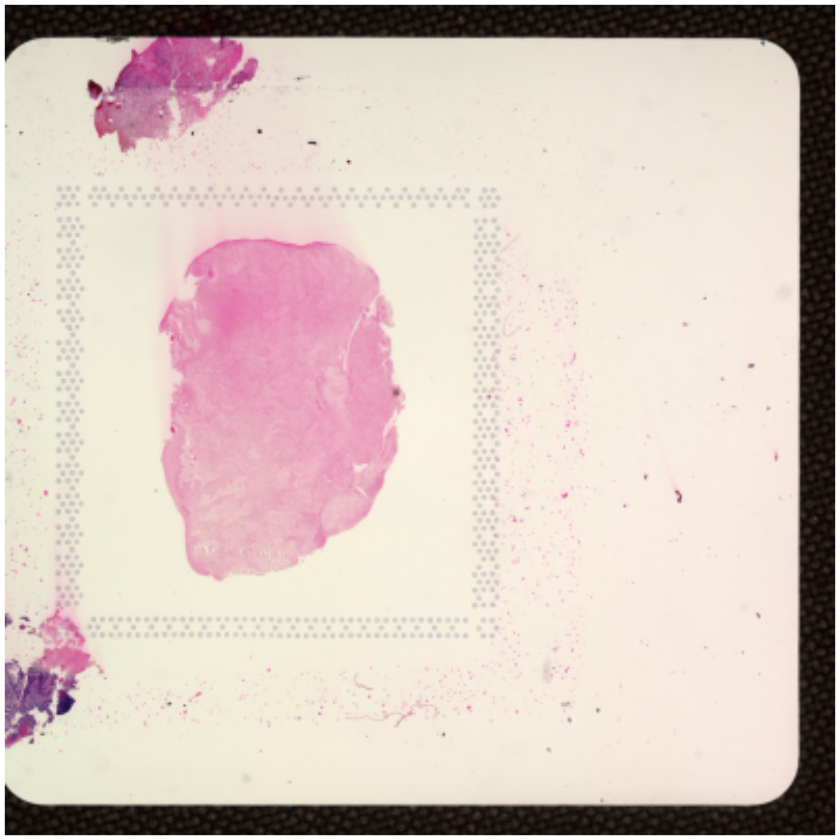

In [7]:
obj <- LoadImages(obj, time.resolve = FALSE)
ImagePlot(obj, method = "raster", annotate = FALSE)

In [ ]:
#Remove debris/spots over splippage
obj <- ManualAnnotation(obj)

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <bc>”


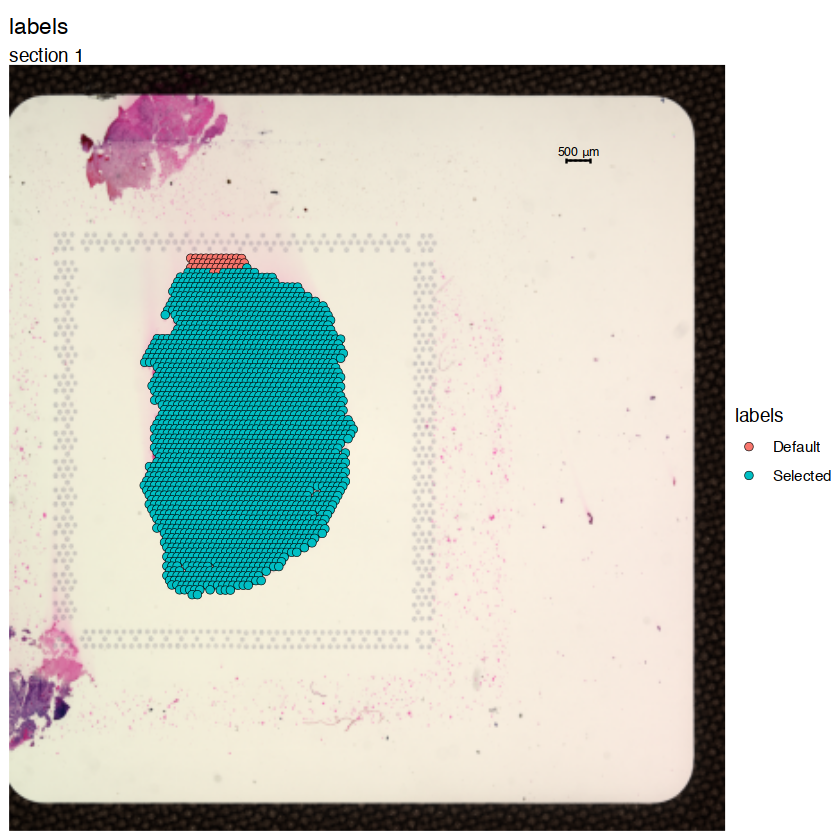

In [10]:
FeatureOverlay(obj, features = "labels")

In [11]:
plot1<- ST.FeaturePlot(obj, features = "nFeature_RNA", 
			   		   cols = c("lightgray", "mistyrose", "red", "dark red", "black"), 
			   		   ncol = 2, pt.size = 2.5)
plot2<- ST.FeaturePlot(obj, features = "nCount_RNA", 
			   		   cols = c("lightgray", "mistyrose", "red", "dark red", "black"), 
			   		   ncol = 2, pt.size = 2.5)
plot3 <- VlnPlot(obj, features = "nCount_RNA", group.by = "orig.ident", pt.size = 0.1)  & theme(axis.title.x = element_blank())
plot4 <- VlnPlot(obj, features = "nFeature_RNA", group.by = "orig.ident", pt.size = 0.1)  & theme(axis.title.x = element_blank())

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <bc>”


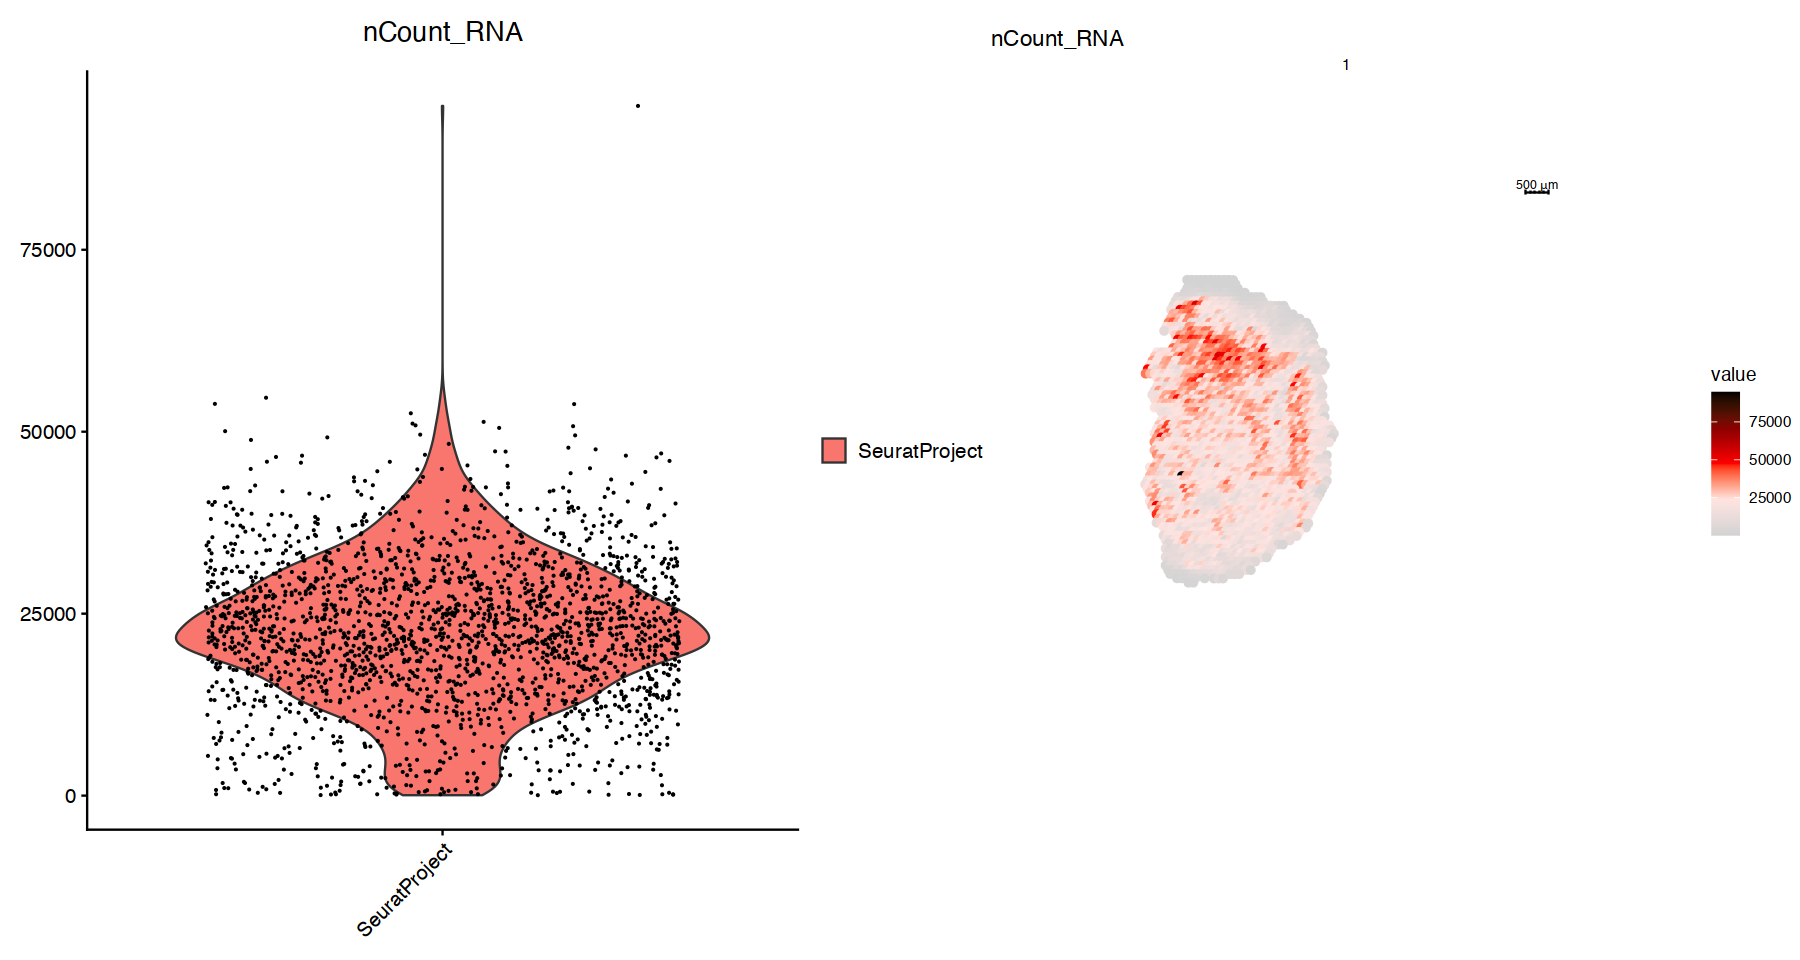

In [12]:
options(repr.plot.width = 15, repr.plot.height = 8)
wrap_plots(plot3, plot2)

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <bc>”


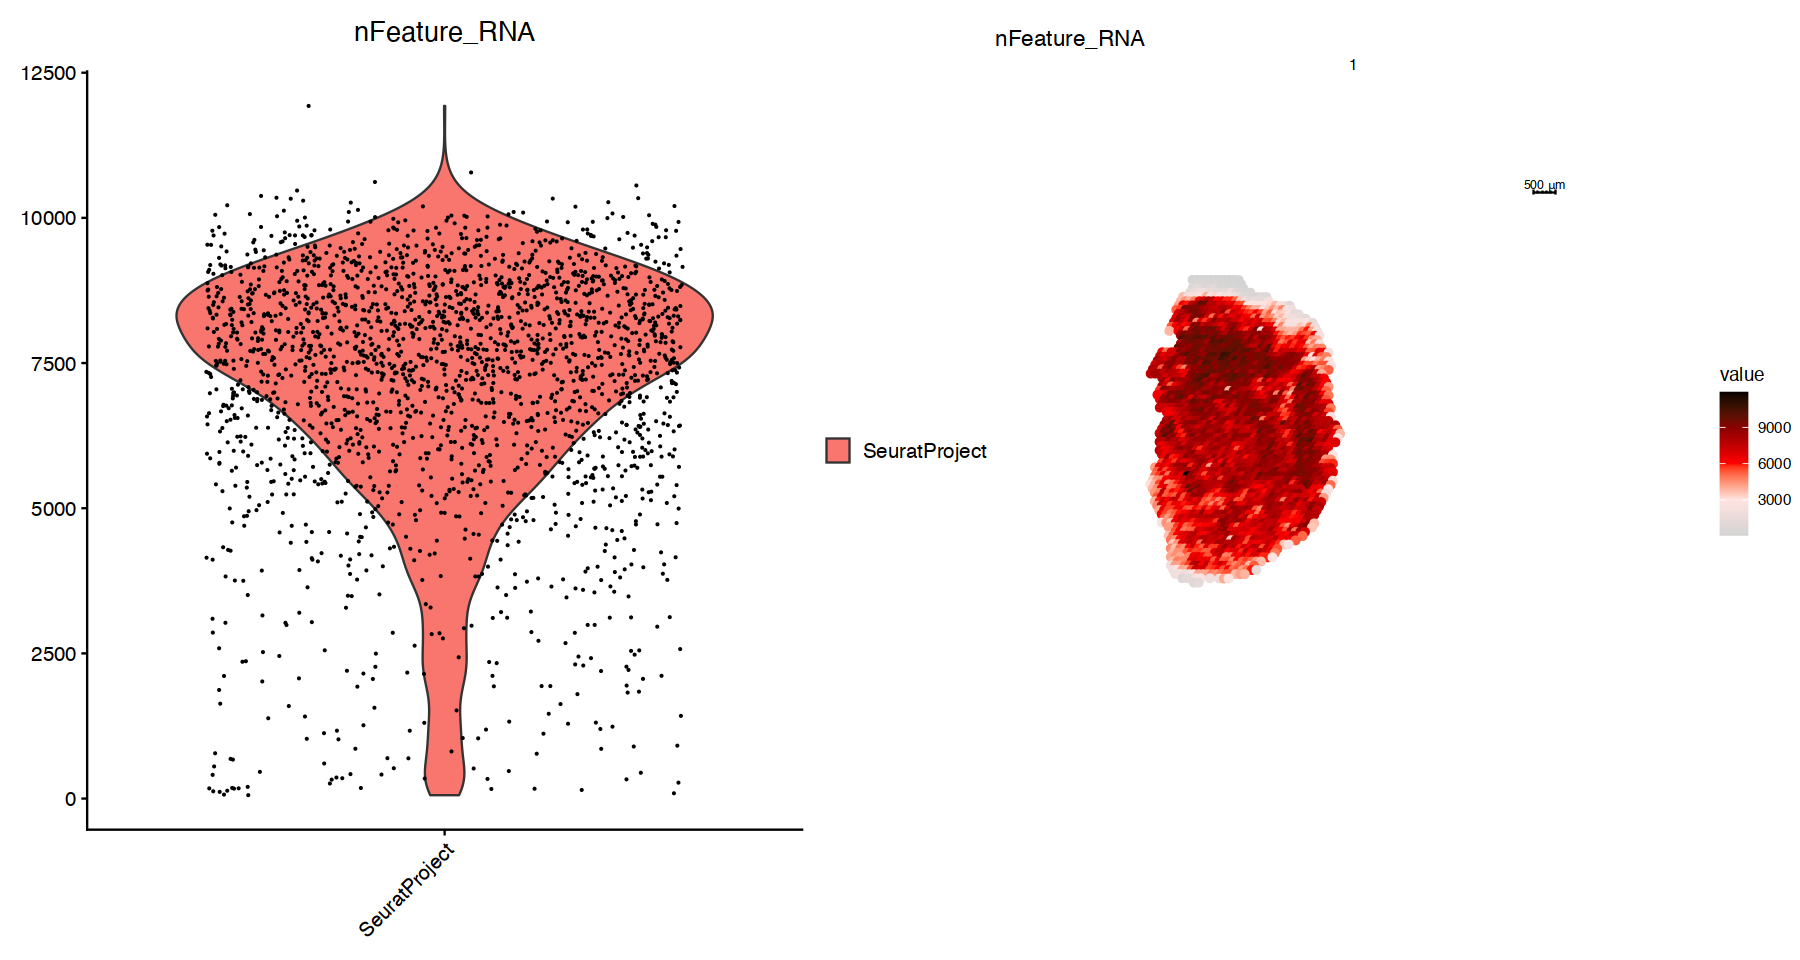

In [13]:
wrap_plots(plot4, plot1)

In [14]:
mt.genes <- grep(pattern = "^MT-", x = rownames(obj), value = TRUE)
obj$percent.mito <- (Matrix::colSums(obj@assays$RNA@counts[mt.genes, ])/Matrix::colSums(obj@assays$RNA@counts))*100

In [15]:
plot5<- ST.FeaturePlot(obj, features = "percent.mito", 
			   		   cols = c("lightgray", "mistyrose", "red", "dark red", "black"), 
			   		   ncol = 2, pt.size = 2)
plot6 <- VlnPlot(obj, features = "percent.mito", group.by = "orig.ident", pt.size = 0.1)  & theme(axis.title.x = element_blank())

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '500 μm' in 'mbcsToSbcs': dot substituted for <bc>”


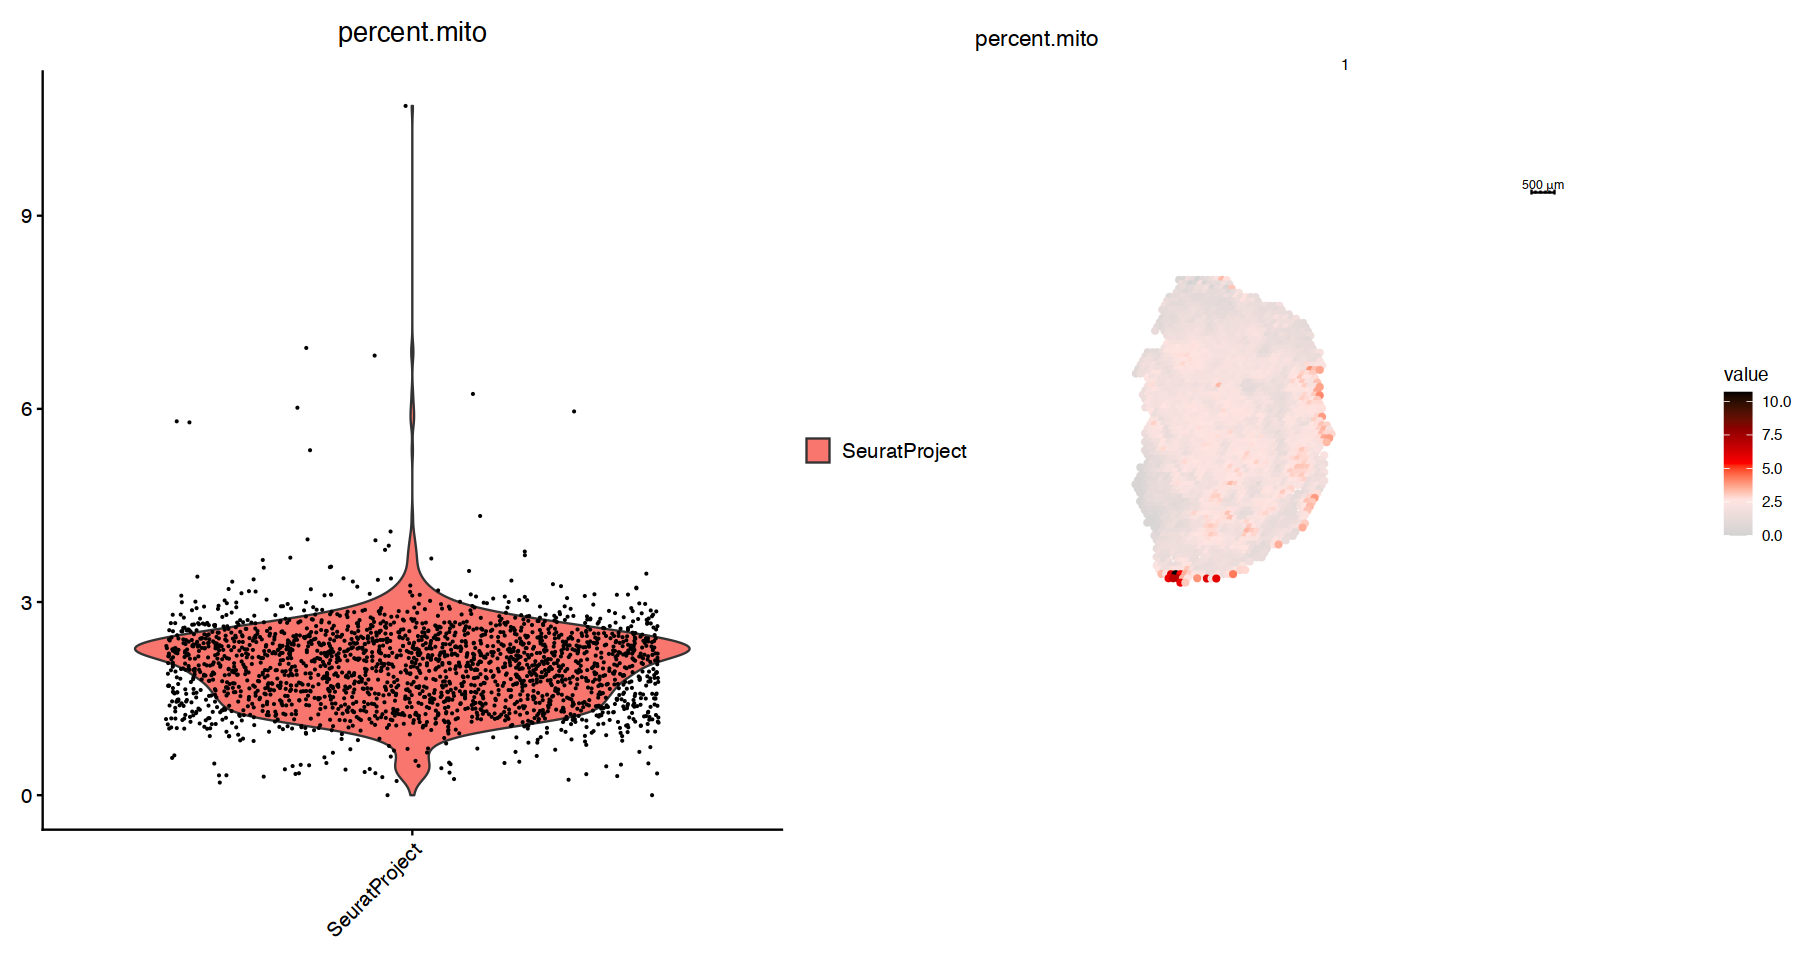

In [16]:
wrap_plots(plot6, plot5)

In [18]:
meta.preqc <- obj@meta.data
meta.preqc <- obj@meta.data
rownames(meta.preqc) <- gsub("_1","",rownames(meta.preqc))
meta.preqc$Barcode <- rownames(meta.preqc)
head(meta.preqc)

orig.ident    nCount_RNA nFeature_RNA id labels 
GTACGAAGGCGTCTAT-1 SeuratProject 223        201          1  Default
AAGGTTACTATGACGC-1 SeuratProject 198        183          2  Default
CGTACATCGATGTCTT-1 SeuratProject 184        171          3  Default
CGGCTTCCTACTGGTT-1 SeuratProject 185        169          4  Default
TCAGTCGAGCGATGAA-1 SeuratProject 182        176          5  Default
GTCCGTACGGATGCTC-1 SeuratProject 120        115          6  Default
                   percent.mito Barcode           
GTACGAAGGCGTCTAT-1 0.4484305    GTACGAAGGCGTCTAT-1
AAGGTTACTATGACGC-1 0.5050505    AAGGTTACTATGACGC-1
CGTACATCGATGTCTT-1 1.6304348    CGTACATCGATGTCTT-1
CGGCTTCCTACTGGTT-1 1.0810811    CGGCTTCCTACTGGTT-1
TCAGTCGAGCGATGAA-1 0.0000000    TCAGTCGAGCGATGAA-1
GTCCGTACGGATGCTC-1 0.8333333    GTCCGTACGGATGCTC-1

In [19]:
meta.preqc <- meta.preqc[,c(7,5:6)]
meta.preqc <- meta.preqc[order(meta.preqc$Barcode),]
head(meta.preqc)

Barcode            labels   percent.mito
AACACTTGGCAAGGAA-1 AACACTTGGCAAGGAA-1 Selected 2.035367    
AACAGGATTCATAGTT-1 AACAGGATTCATAGTT-1 Selected 2.308890    
AACAGGTTATTGCACC-1 AACAGGTTATTGCACC-1 Selected 1.160414    
AACAGGTTCACCGAAG-1 AACAGGTTCACCGAAG-1 Selected 1.257742    
AACATCTAATGACCGG-1 AACATCTAATGACCGG-1 Selected 1.287177    
AACCAAGGTATCAGGC-1 AACCAAGGTATCAGGC-1 Selected 3.368533

## QC and filtering

In [20]:
# Import Visium ST data
# ----------
#    Inputs:
#    Data directory path and filename (file.h5)
#    Outputs:
#    Seurat object with stored count and gene expression data
# ----------
obj <- Load10X_Spatial(datadir1, filename = "filtered_feature_bc_matrix.h5", 
                       assay = "Spatial", 
                       slice = "tumor")
obj$orig.ident <- "19h1257-1_PP"
obj$response <- "NR"

In [21]:
head(obj@meta.data)

orig.ident   nCount_Spatial nFeature_Spatial response
AACACTTGGCAAGGAA-1 19h1257-1_PP 30707          8949             NR      
AACAGGATTCATAGTT-1 19h1257-1_PP 26333          8419             NR      
AACAGGTTATTGCACC-1 19h1257-1_PP 16632          6095             NR      
AACAGGTTCACCGAAG-1 19h1257-1_PP 20990          6931             NR      
AACATCTAATGACCGG-1 19h1257-1_PP 22763          7336             NR      
AACCAAGGTATCAGGC-1 19h1257-1_PP 16951          6843             NR

In [22]:
labs <- meta.preqc$labels
names(labs) <- meta.preqc$Barcode
obj <- AddMetaData(obj, labs, col.name = "labels")
head(obj@meta.data)

orig.ident   nCount_Spatial nFeature_Spatial response
AACACTTGGCAAGGAA-1 19h1257-1_PP 30707          8949             NR      
AACAGGATTCATAGTT-1 19h1257-1_PP 26333          8419             NR      
AACAGGTTATTGCACC-1 19h1257-1_PP 16632          6095             NR      
AACAGGTTCACCGAAG-1 19h1257-1_PP 20990          6931             NR      
AACATCTAATGACCGG-1 19h1257-1_PP 22763          7336             NR      
AACCAAGGTATCAGGC-1 19h1257-1_PP 16951          6843             NR      
                   labels  
AACACTTGGCAAGGAA-1 Selected
AACAGGATTCATAGTT-1 Selected
AACAGGTTATTGCACC-1 Selected
AACAGGTTCACCGAAG-1 Selected
AACATCTAATGACCGG-1 Selected
AACCAAGGTATCAGGC-1 Selected

In [23]:
pmt <- meta.preqc$percent.mito
names(pmt) <- meta.preqc$Barcode
obj <- AddMetaData(obj, pmt, col.name = "percent.mito")
head(obj@meta.data)

orig.ident   nCount_Spatial nFeature_Spatial response
AACACTTGGCAAGGAA-1 19h1257-1_PP 30707          8949             NR      
AACAGGATTCATAGTT-1 19h1257-1_PP 26333          8419             NR      
AACAGGTTATTGCACC-1 19h1257-1_PP 16632          6095             NR      
AACAGGTTCACCGAAG-1 19h1257-1_PP 20990          6931             NR      
AACATCTAATGACCGG-1 19h1257-1_PP 22763          7336             NR      
AACCAAGGTATCAGGC-1 19h1257-1_PP 16951          6843             NR      
                   labels   percent.mito
AACACTTGGCAAGGAA-1 Selected 2.035367    
AACAGGATTCATAGTT-1 Selected 2.308890    
AACAGGTTATTGCACC-1 Selected 1.160414    
AACAGGTTCACCGAAG-1 Selected 1.257742    
AACATCTAATGACCGG-1 Selected 1.287177    
AACCAAGGTATCAGGC-1 Selected 3.368533

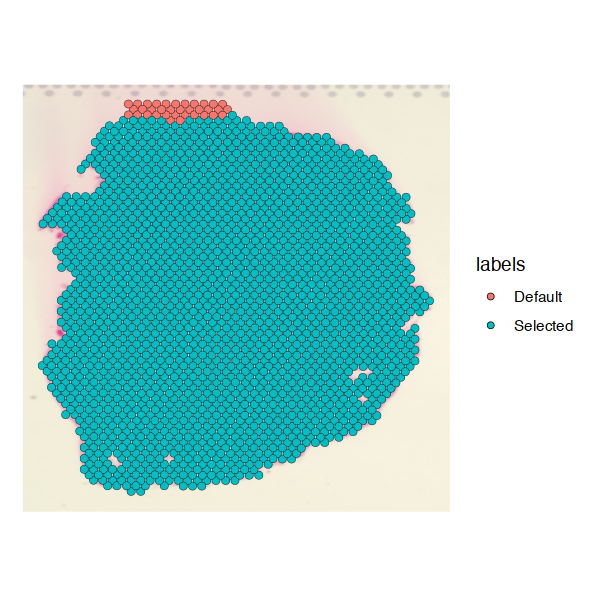

In [24]:
SpatialPlot(obj,group.by="labels",pt.size.factor=3) + theme(legend.position = "right")

In [25]:
table(obj@meta.data$labels)


 Default Selected 
      35     2205 

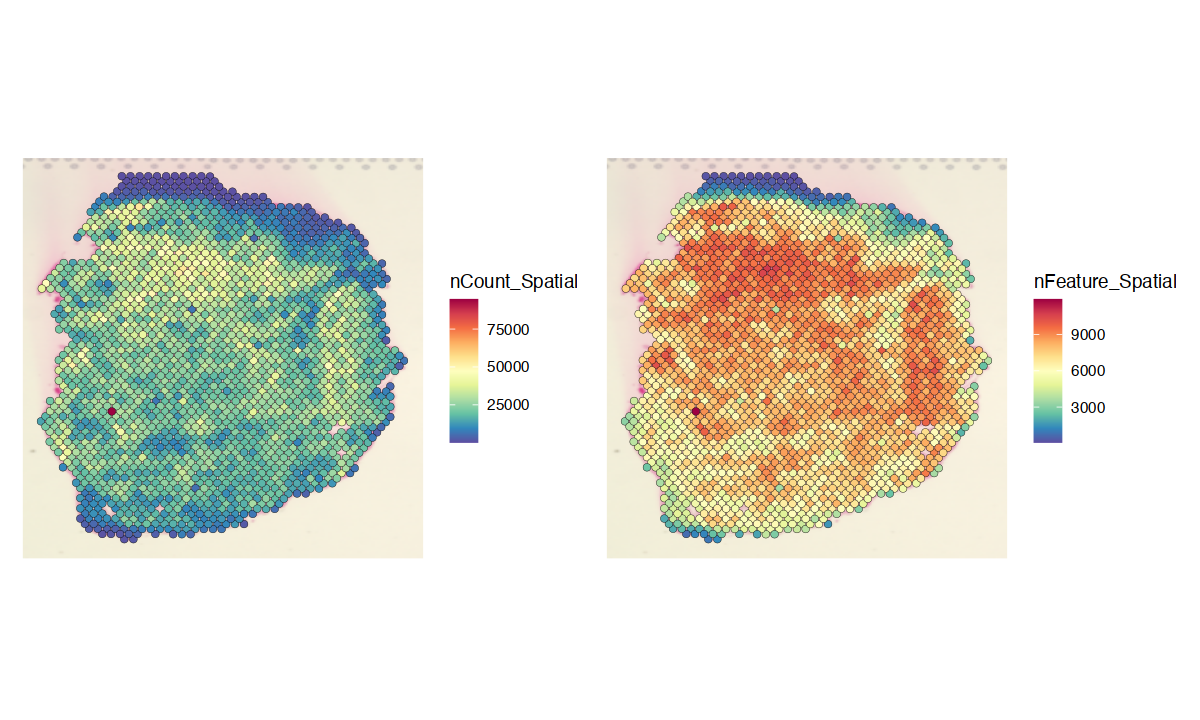

In [27]:
# Initial data visualization for QC
## Note: there were no mito or ribo probs in this dataset (= QC must be done on read and gene counts only)

#Plots of number of read of each sample -> "Tumor" sample (grey) really high in features and counts and thus was excluded due to techinical processing issues 
plot2 <- SpatialFeaturePlot(obj, features = "nCount_Spatial", pt.size.factor = 3) + theme(legend.position = "right")
plot4 <- SpatialFeaturePlot(obj, features = "nFeature_Spatial", pt.size.factor = 3) + theme(legend.position = "right")

options(repr.plot.width = 10, repr.plot.height = 6)
wrap_plots(plot2, plot4)

In [28]:
#Remove debris spots
obj <- subset(obj, labels == "Selected")
table(obj@meta.data$labels)


Selected 
    2205 

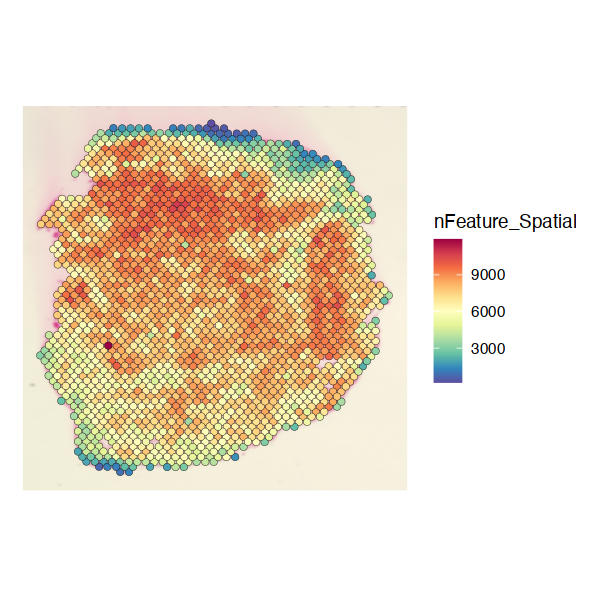

In [29]:
options(repr.plot.width = 5, repr.plot.height = 5)
SpatialFeaturePlot(obj, features = "nFeature_Spatial", pt.size.factor = 3) + theme(legend.position = "right")

In [30]:
# Data QC
# ----------
# Function generates distribution plots for each sample and dataset (features/counts) to observe 
# which values/how many values are outliers 
# ----------
filter_data_pots <- function(sr_ob, outdir, sampleID) {
 
  log_low_ncount_threshold = median(log(sr_ob$nCount_Spatial)) - 3*mad(log(sr_ob$nCount_Spatial))
  log_high_ncount_threshold = median(log(sr_ob$nCount_Spatial)) + 3*mad(log(sr_ob$nCount_Spatial))
  log_low_nfeature_threshold = median(log(sr_ob$nFeature_Spatial)) - 3*mad(log(sr_ob$nFeature_Spatial))
  log_high_nfeature_threshold = median(log(sr_ob$nFeature_Spatial)) + 3*mad(log(sr_ob$nFeature_Spatial))
  
  low_ncount_threshold = median(sr_ob$nCount_Spatial) - 3*mad(sr_ob$nCount_Spatial)
  high_ncount_threshold = median(sr_ob$nCount_Spatial) + 3*mad(sr_ob$nCount_Spatial)
  low_nfeature_threshold = median(sr_ob$nFeature_Spatial)- 3*mad(sr_ob$nFeature_Spatial)
  high_nfeature_threshold = median(sr_ob$nFeature_Spatial) + 3*mad(sr_ob$nFeature_Spatial)
  
  
  ncount_norm <- ggplot(sr_ob@meta.data, aes(x=nCount_Spatial))+geom_histogram(aes(y=..density..),bins=200,fill="grey")+geom_density() +geom_vline(aes(xintercept=low_ncount_threshold),color = "red") +geom_vline(aes(xintercept=high_ncount_threshold),color = "blue") + geom_vline(aes(xintercept=200), color = "green")
  
  ncount_log <- ggplot(sr_ob@meta.data, aes(x=log(nCount_Spatial)))+geom_histogram(aes(y=..density..),bins=200,fill="grey")+geom_density() +geom_vline(aes(xintercept=log_low_ncount_threshold),color = "red") +geom_vline(aes(xintercept=log_high_ncount_threshold),color = "blue") + geom_vline(aes(xintercept= log(200)), color = "green")
  
    nfeature_norm <- ggplot(sr_ob@meta.data, aes(x=nFeature_Spatial))+geom_histogram(aes(y=..density..),bins=200,fill="grey")+geom_density() +geom_vline(aes(xintercept=low_nfeature_threshold),color = "red") +geom_vline(aes(xintercept=high_nfeature_threshold),color = "blue")+ geom_vline(aes(xintercept=100), color = "green") 
 
    nfeature_log <- ggplot(sr_ob@meta.data, aes(x=log(nFeature_Spatial)))+geom_histogram(aes(y=..density..),bins=200,fill="grey")+geom_density() +geom_vline(aes(xintercept=log_low_nfeature_threshold),color = "red") +geom_vline(aes(xintercept=log_high_nfeature_threshold),color = "blue") + geom_vline(aes(xintercept= log(200)), color = "green")
  
    ncount_norm+ncount_log+nfeature_norm+nfeature_log+labs(caption =  paste0("LRT: ",format(round(low_ncount_threshold,2),nsmall=2), ", HRT: ", format(round(high_ncount_threshold,2),nsmall=2), ", LFT: ",format(round(low_nfeature_threshold,2),nsmall=2), ", HFT: ", format(round(high_nfeature_threshold,2),nsmall=2), "  /   LOG -> ","LRT: ",format(round(log_low_ncount_threshold,2),nsmall=2), ", HRT: ", format(round(log_high_ncount_threshold,2),nsmall=2), ", LFT: ",format(round(log_low_nfeature_threshold,2),nsmall=2), ", HFT: ", format(round(log_high_nfeature_threshold,2),nsmall=2)))
}

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


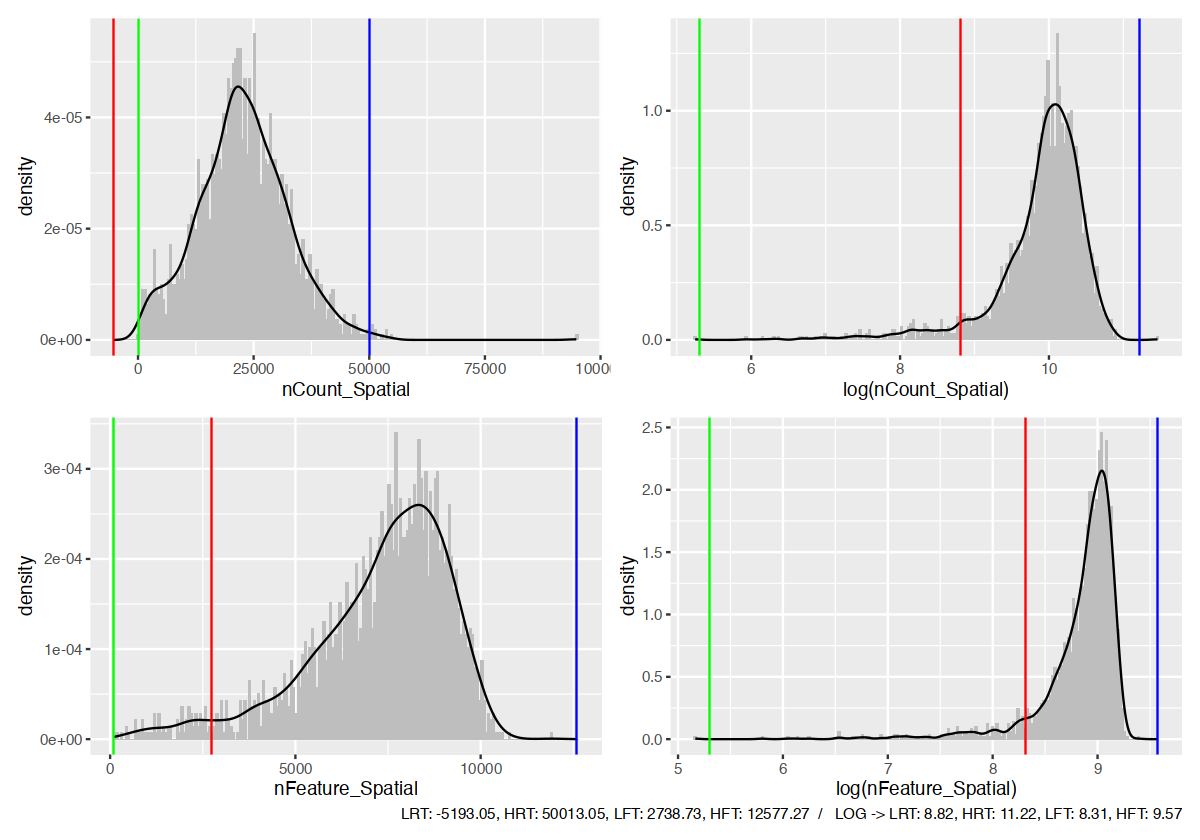

In [31]:
#Red   = lower threshold (-3*MAD)
#Blue  = upper threshold ( +3*MAD)
#Green = generic threshold (200 reads/genes)
options(repr.plot.width = 10, repr.plot.height = 7)
filter_data_pots(obj, outputdir, "19h1257-1_PP")

In [32]:
# Remove outlier spots
# Spots with low read and gene counts were removed, also genes present in <3 spots were also removed
filter_data <- function(sr_ob, outdir, sampleID) {


  selected_f <-rownames(sr_ob)[Matrix::rowSums(sr_ob)>3] #filters genes which are expressed in atleast 3 cells
  removed_f <-rownames(sr_ob)[Matrix::rowSums(sr_ob)<=3]
  
  write.table(removed_f, file = paste0(outdir, "/",sampleID, "_removed_genes.txt"), sep = "\t", quote = FALSE, col.names = NA)
 
  data.filt <-subset(sr_ob, features = selected_f)
  
  #note: replace type with "both" -> DO I LOG TRANSFORM BEFORE FILTERING?
  mad_reads.low <- isOutlier(data.filt$nCount_Spatial, nmads = 3, type = "lower")
  mad_reads.high <- isOutlier(data.filt$nCount_Spatial, nmads = 3, type = "higher")
  mad_gene.low <- isOutlier(data.filt$nFeature_Spatial, nmads = 3, type = "lower")
  mad_gene.high <- isOutlier(data.filt$nFeature_Spatial, nmads = 3, type = "higher")
  
  
  log_mad_reads.low <- isOutlier(data.filt$nCount_Spatial, nmads = 3, type = "lower", log = TRUE)
  log_mad_reads.high <- isOutlier(data.filt$nCount_Spatial, nmads = 3, type = "higher", log = TRUE)
  log_mad_gene.low <- isOutlier(data.filt$nFeature_Spatial, nmads = 3, type = "lower", log = TRUE)
  log_mad_gene.high <- isOutlier(data.filt$nFeature_Spatial, nmads = 3, type = "higher", log = TRUE)
  
  
  total.low <- mad_reads.low|mad_gene.low
  total.high<-mad_reads.high|mad_gene.high
  total.log.low <- log_mad_reads.low|log_mad_gene.low
  total.log.high <-log_mad_reads.high|log_mad_gene.high

  data.filt <- AddMetaData(data.filt, total.low, col.name = "low_outliers")
  data.filt <- AddMetaData(data.filt, total.high, col.name = "high_outliers")
  data.filt <- AddMetaData(data.filt, total.log.low, col.name = "LOG_low_outliers")
  data.filt <- AddMetaData(data.filt, total.log.high, col.name = "LOG_high_outliers")
 


  df <- data.frame(QCtype = c("RawTotalReads","RawTotalGenes","HighReadCounts","LowReadCounts","HighGene","LowGene","Gene_In_<3_Cells"), value= c(length(Cells(data.filt)),length(rownames(data.filt)),sum(mad_reads.high),sum(mad_reads.low),sum(mad_gene.high), sum(mad_gene.low), length(removed_f)))

   plot1 <- ggplot(data=df, aes(x = QCtype, y = value)) + 
   			geom_bar(stat = "identity", fill = "steelblue") + 
   			geom_text(aes(label = value), vjust = -0.3, size = 2) +
   			theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
   
  
  #discard <- mad_reads.low|mad_gene.low # just removed low reads and genes
  #discard <- total.log.low

  #Remove poor quality data
  #filtered <- data.filt[,which(discard == "FALSE")]
  filtered <- subset(data.filt, subset = nFeature_Spatial > 200) #filters cells which have more then 100 genes detected
  filtered <- subset(data.filt, subset = percent.mito < 10) #filters out cells which less than 10% mito content
  plot2 <- SpatialDimPlot(filtered)
  plot3 <- SpatialDimPlot(data.filt)
  plot1|(plot2/plot3)
  ggsave(paste0(outdir,"/",sampleID, "_QC_removed_values_nonlog.pdf" ))
  #g1 = ggplot(as.data.frame())
  
  
  return(filtered)
}

In [33]:
outputdir1 <- paste0(outputdir,"/Data_QC")
dir.create(outputdir1)

obj_out <- filter_data(obj,outputdir1,"19h1257-1_PP")

Saving 7 x 7 in image


In [34]:
check_outliers <- function(sr_ob) {
  p1 <- SpatialDimPlot(sr_ob, group.by = "low_outliers",pt.size.factor=3)
  p2 <- SpatialDimPlot(sr_ob, group.by = "high_outliers",pt.size.factor=3)
  p3 <- SpatialDimPlot(sr_ob, group.by = "LOG_low_outliers",pt.size.factor=3)
  p4 <- SpatialDimPlot(sr_ob, group.by = "LOG_high_outliers",pt.size.factor=3)
  p1+p2+p3+p4
}

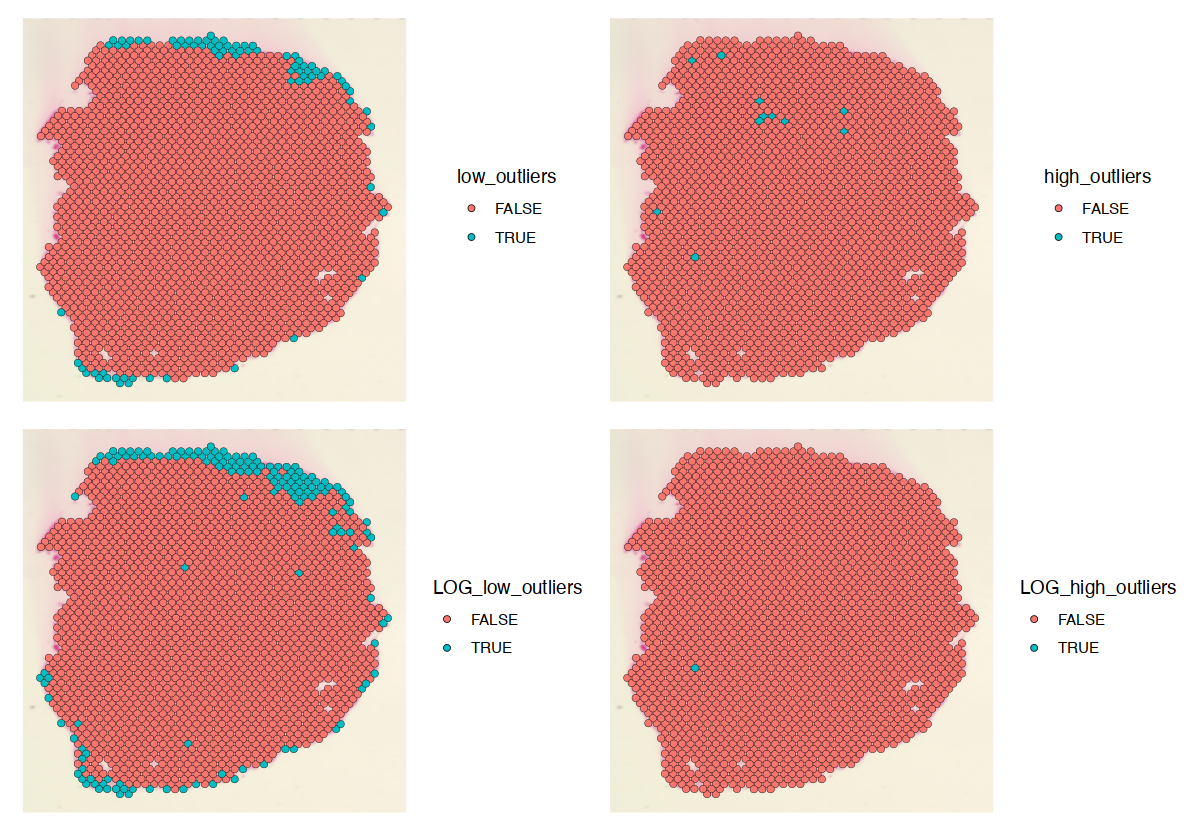

In [35]:
options(repr.plot.width = 10, repr.plot.height = 7)
check_outliers(obj_out)

In [36]:
table(obj_out$LOG_high_outliers)


FALSE  TRUE 
 2203     1 

In [37]:
table(obj_out$LOG_low_outliers)


FALSE  TRUE 
 2049   155 

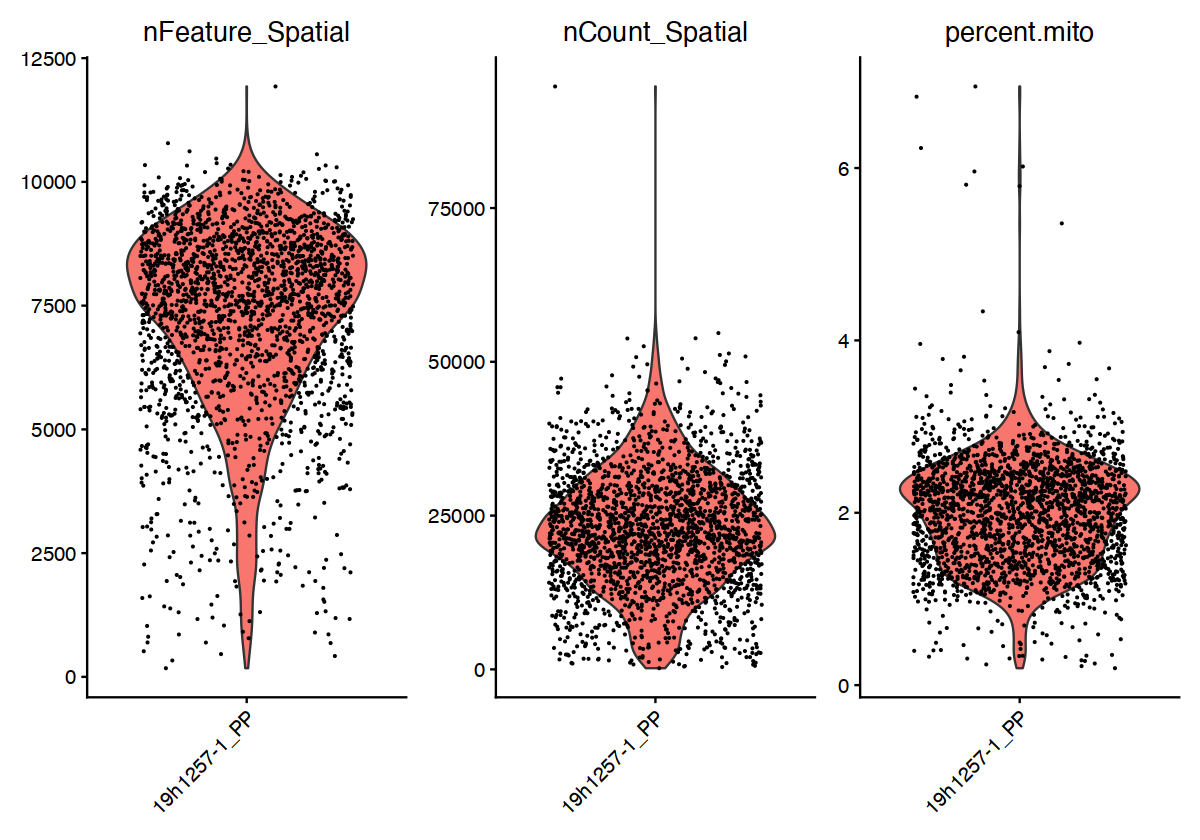

In [38]:
VlnPlot(obj_out, features = c("nFeature_Spatial","nCount_Spatial","percent.mito"), group.by = "orig.ident", pt.size = 0.1)  & theme(axis.title.x = element_blank())

## Normalization and clustering

In [39]:
# Normalise data with SCTransform
obj_norm <- SCTransform(obj_out, assay = "Spatial", verbose = FALSE, return.only.var.genes= TRUE)

In [ ]:
obj_norm <- ScaleData(obj_norm)
obj_norm <- RunPCA(obj_norm,   verbose = FALSE, npcs = 100)

In [41]:
# calculate variance explained by each PC
total_variance <- obj_norm@reductions$pca@misc$total.variance
eigValues <- (obj_norm[["pca"]]@stdev)^2
varExplained <- eigValues / total_variance
varExplained.cum <- cumsum(varExplained)
### how many PCs before 20 % of the variance is explained?
var.20pc <- sum(varExplained.cum <= 0.2)
### how much variance do 50 PCs explain?
varpc.50PCA <- 100*(varExplained.cum[50])
print(paste0("The first 50 PCs explain ", round(varpc.50PCA), "% of the variance. 20% of the variance is explained by the first ", var.20pc, " PCs"))

[1] "The first 50 PCs explain 33% of the variance. 20% of the variance is explained by the first 3 PCs"


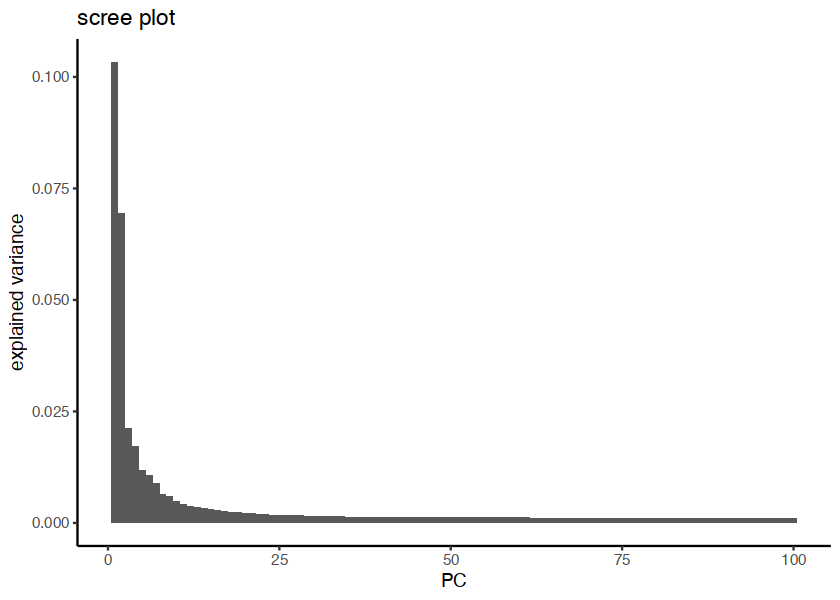

In [42]:
# define some graph functions which will be run with `to.pdf` later
## scree plot
options(repr.plot.width = 7, repr.plot.height = 5)
varExplained %>% enframe(name = "PC", value = "varExplained" ) %>%
    ggplot(aes(x = PC, y = varExplained)) + 
    theme_bw() +
    geom_bar(stat = "identity") +
    theme_classic() +
    ggtitle("scree plot") +
    ylab("explained variance")

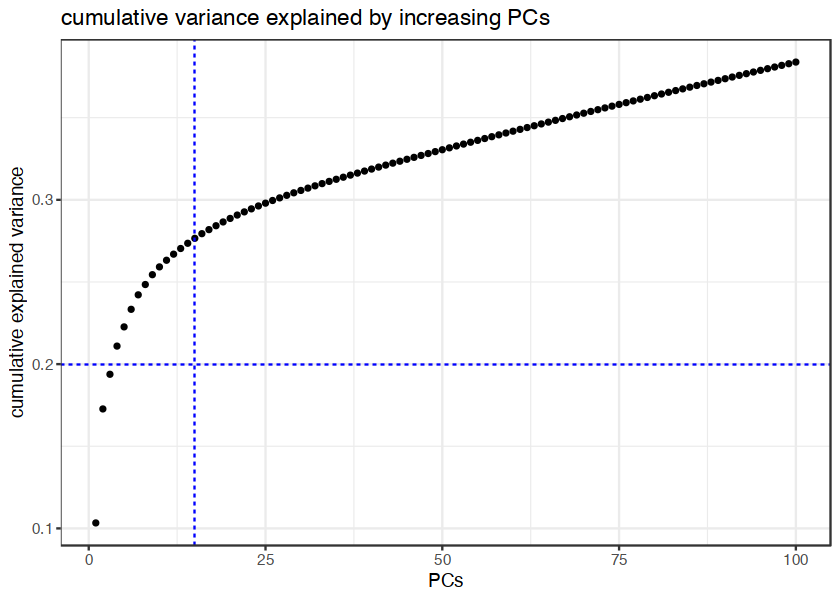

In [43]:
## cumulative variance
ggplot(as.data.frame(varExplained.cum), aes(y = varExplained.cum, x = seq(1, length(varExplained.cum)))) +
geom_point(size = 1) +
theme_bw() +
ggtitle("cumulative variance explained by increasing PCs") +
xlab("PCs") +
ylab("cumulative explained variance") +
geom_hline(yintercept = c(0.2), linetype = "dashed", color = "blue") +
geom_vline(xintercept = c(15), linetype = "dashed", color = "blue")

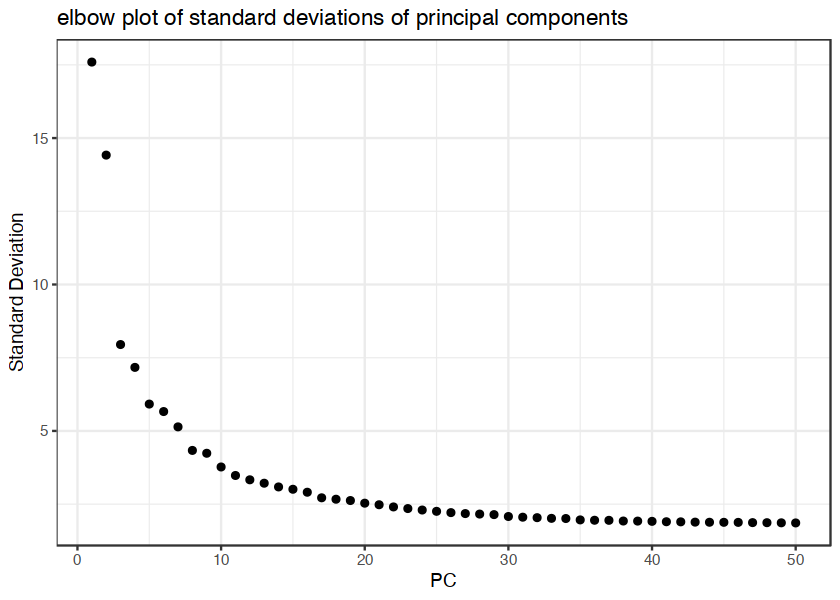

In [44]:
ElbowPlot(obj_norm, ndims = 50, reduction = "pca") +
theme_bw() +
ggtitle("elbow plot of standard deviations of principal components")

In [ ]:
obj_norm <- FindNeighbors(obj_norm, dims = 1:15)
obj_norm <- RunUMAP(obj_norm, reduction = "pca", dims = 1:15)

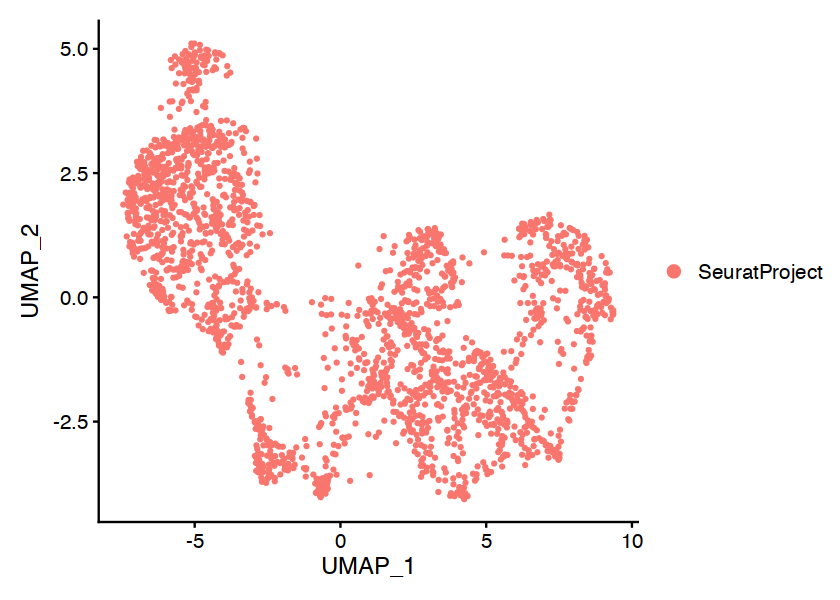

In [48]:
DimPlot(obj_norm, reduction = "umap")

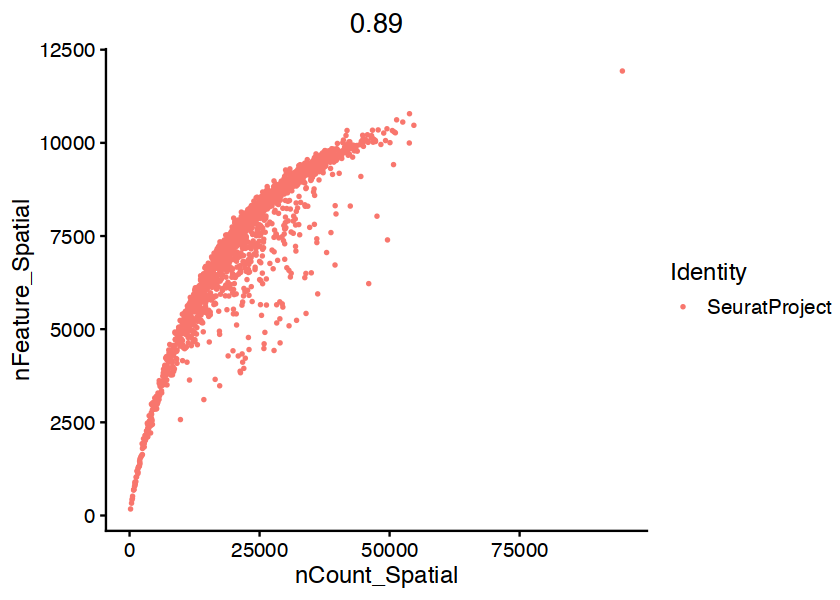

In [49]:
FeatureScatter(obj_norm, "nCount_Spatial","nFeature_Spatial", pt.size = 0.5)

In [ ]:
int.outputdir <- paste0(outputdir, "/Clustering")
dir.create(int.outputdir)

#iterate over various clustering resolutions to determine the best one based on the stability of clustering produced
df.2 <- NULL
df.2 <- FindClusters(obj_norm, resolution = 0)
df.2 <- FindClusters(df.2, resolution = 0.1)
df.2 <- FindClusters(df.2, resolution = 0.2)
df.2 <- FindClusters(df.2, resolution = 0.3)
df.2 <- FindClusters(df.2, resolution = 0.4)
df.2 <- FindClusters(df.2, resolution = 0.6)
df.2 <- FindClusters(df.2, resolution = 0.8)
df.2 <- FindClusters(df.2, resolution = 1)
df.2 <- FindClusters(df.2, resolution = 1.2)
df.2 <- FindClusters(df.2, resolution = 1.4)
df.2 <- FindClusters(df.2, resolution = 1.6)

clust <- clustree(df.2, prefix = "SCT_snn_res.", node_colour = "sc3_stability")

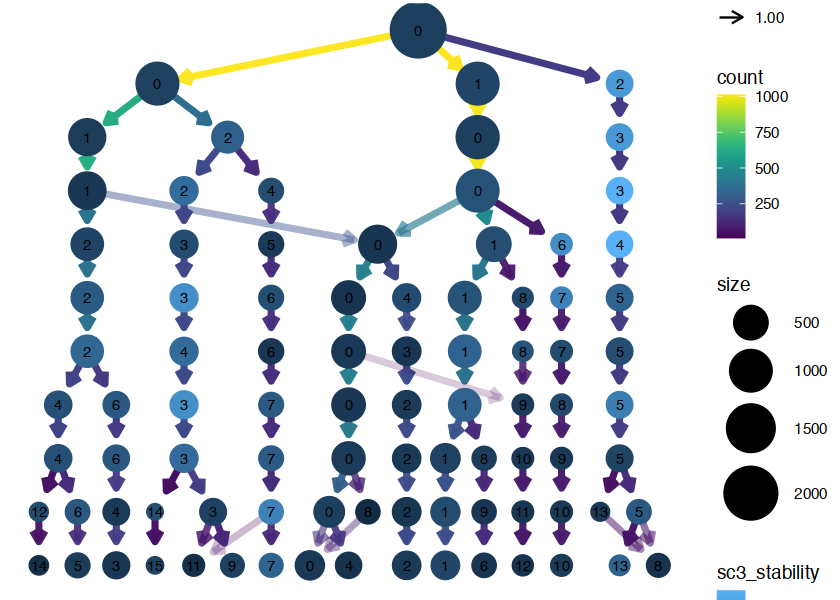

In [51]:
clust #clustering at each resultion and how clusters branch

In [ ]:
stability <- clust$data[,c("SCT_snn_res.", "sc3_stability")]
write.table(stability, file = paste0(int.outputdir, "/integrated_data_clustree_stability.txt"), sep = "\t", quote = FALSE, row.names = FALSE, col.names = TRUE)
stability.ave <- aggregate(as.numeric(stability$sc3_stability), list(stability$SCT_snn_res.), mean)
rownames(stability.ave) <- stability.ave$Group.1
stability.ave$Group.1 <- NULL
bestres <- as.numeric(rownames(stability.ave)[which.max(stability.ave$x)])
bestres #This is the best resolution

In [ ]:
########### VISULISE DATA INTEGRATION #########
obj_norm <- FindClusters(obj_norm, resolution = bestres)
obj_norm <- RunUMAP(obj_norm, reduction = "pca", dims = 1:15)

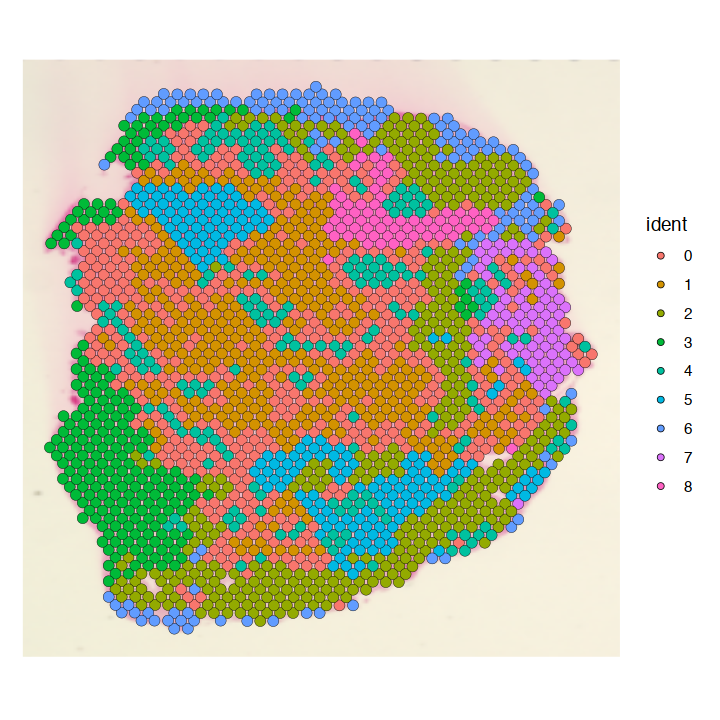

In [62]:
options(repr.plot.width = 6, repr.plot.height = 6)
SpatialDimPlot(obj_norm,pt.size.factor=3)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


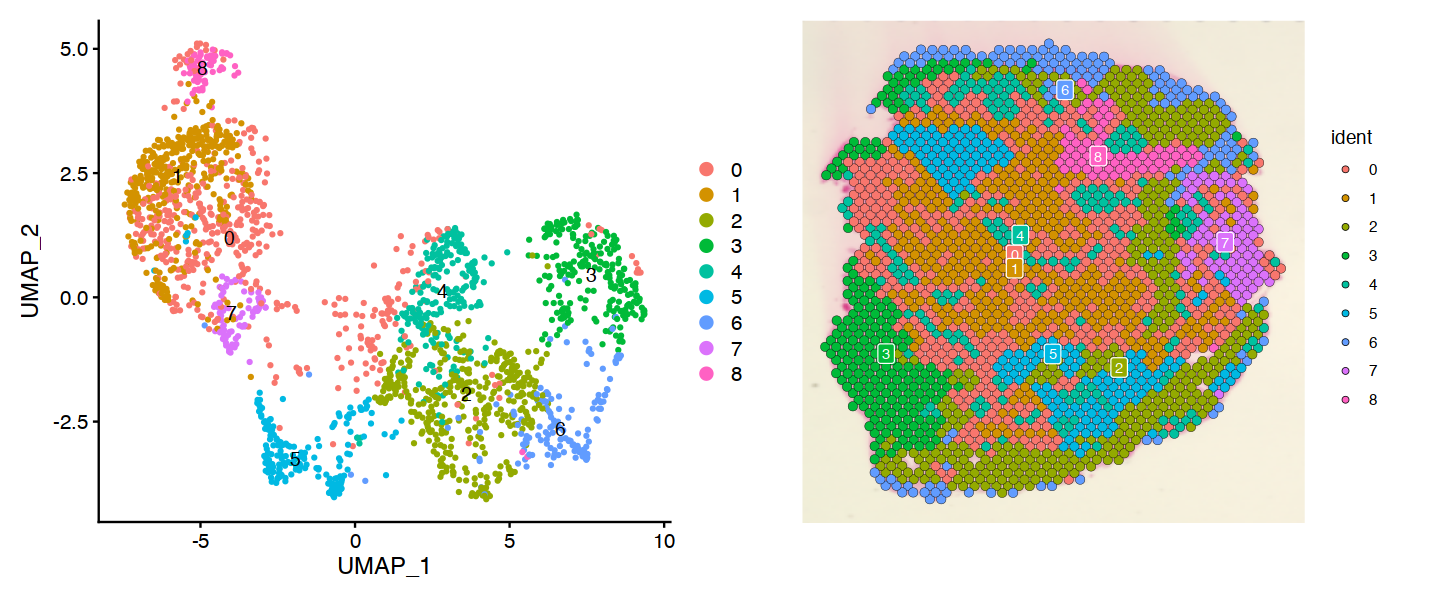

In [63]:
options(repr.plot.width = 12, repr.plot.height = 5)
p1 <- DimPlot(obj_norm, reduction = "umap", label = TRUE)
p2 <- SpatialDimPlot(obj_norm, label = TRUE, label.size = 3,pt.size.factor=3)
p1 + p2

In [ ]:
#Cluster markers
Idents(obj_norm) <- "seurat_clusters"
top_markers <- FindAllMarkers(obj_norm, only.pos = TRUE)

In [65]:
table(top_markers$cluster)


   0    1    2    3    4    5    6    7    8 
 358 2638 1422  907  568 2284  537 1689 1983 

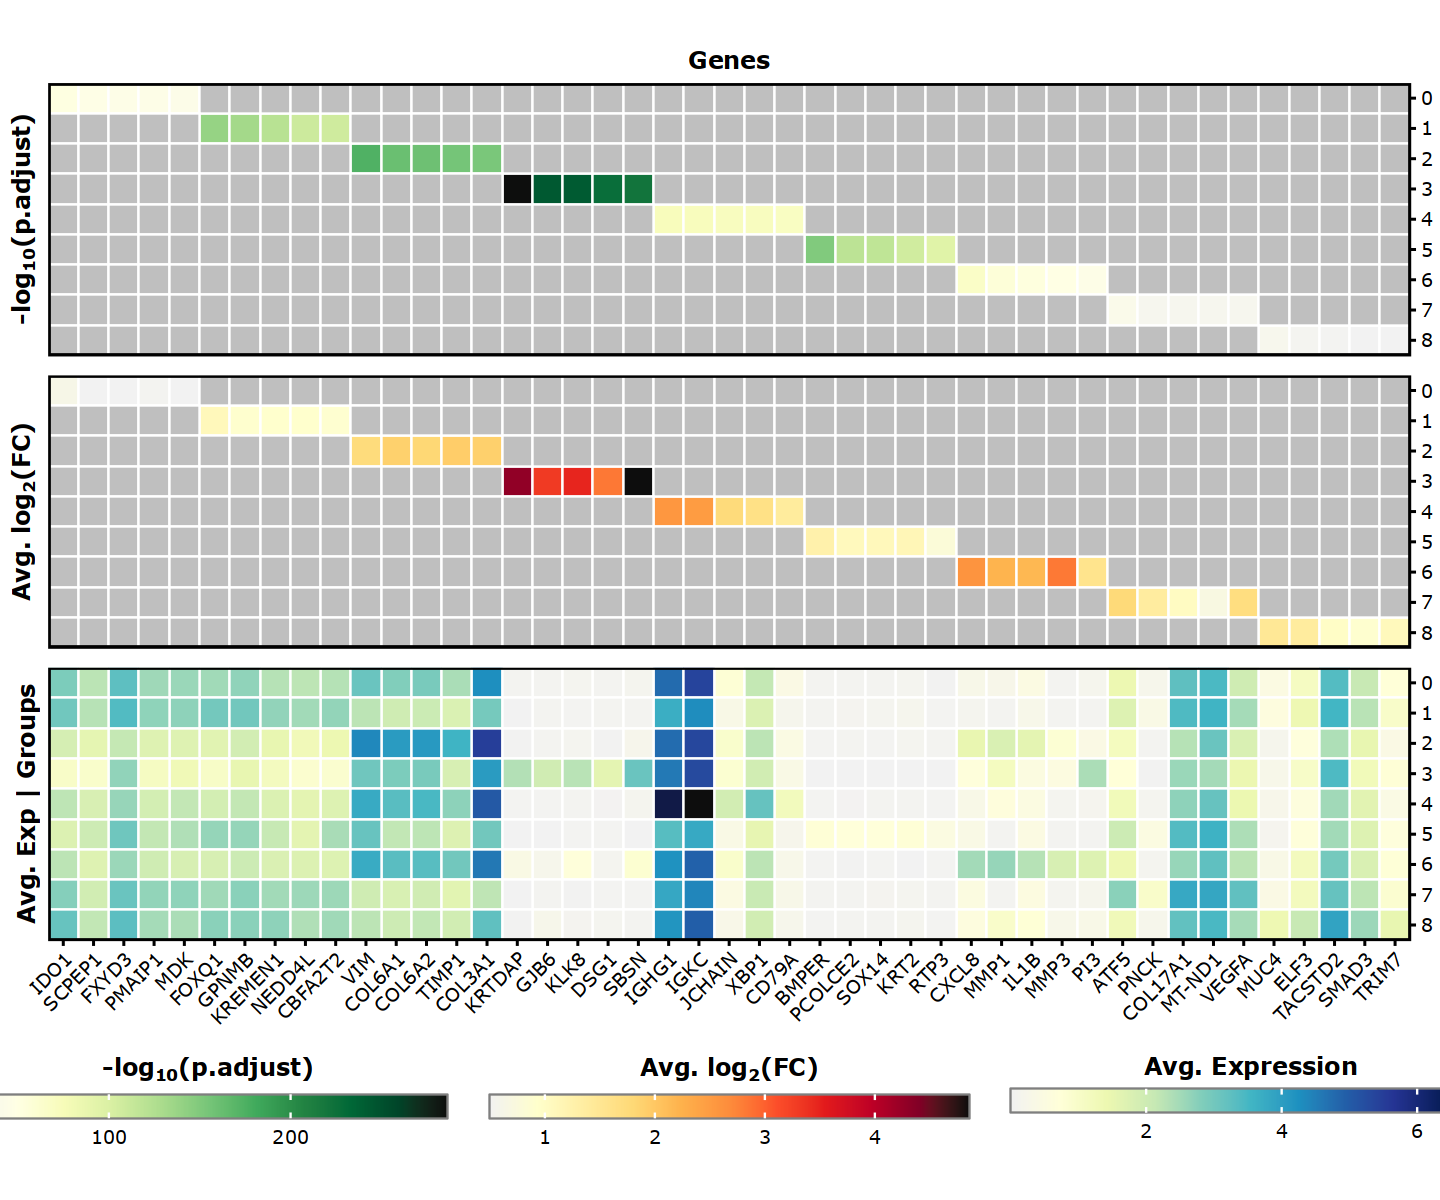

In [66]:
options(repr.plot.width = 12, repr.plot.height = 10)
SCpubr::do_GroupwiseDEPlot(sample = obj_norm,
                           de_genes = tibble::tibble(top_markers),
                           top_genes = 5)

## Cell cycle prediction

In [67]:
## Cell cycle prediction
# This code produces plots for each sample (using integrated dataset) to display cell cycles stage of each spot -> found that alot of tumour regions in S and G2M phase
cell_cycle.outputdir <- paste0(outputdir, "/Cell_Cycle")
dir.create(cell_cycle.outputdir)

func_predictCellCycle <- function(seuratObj, myspecies="human", outdir,sampleID){
  # USAGE: seuratObj <- func_predictCellCycle(seuratObj, "mouse")
  # OUTPUT: a Seurat object with S/G2M-phase scores and cell stage (G1, S, G2M) calls

  # specify the gene set used for Cell Cycle Scoring (human or mouse)
  if (identical(myspecies, "mouse")) {
    load("mouse.cc.genes.Rdata")
    geneset <- mouse.cc.genes
  } else if (identical(myspecies, "human")) {
    geneset <- cc.genes.updated.2019
  } else {
    stop("The 'species' argument must be mouse or human")
  }

  # make a Seurat object, normalise, run prediction
  # note: we use Seurat's default normalisation tool for the cell phase assessment (quick and dirty). Later we will use Scran for the normal normalisation

  seuratObj <- CellCycleScoring(seuratObj,
                                s.features = geneset$s.genes,
                                g2m.features = geneset$g2m.genes,
                                set.ident = TRUE)

  # define some graph functions which will be run with `to.pdf` later
  fig.cellcycle.bar <- function() {
    pdf(paste0(outdir,"/",sampleID, "_CellCycle_bar.pdf"))
    myscale <- round(max(table(seuratObj$Phase)), -3) #scale
    mybar <- barplot(table(seuratObj$Phase),
                     ylim = (c(0, myscale)),
                     main = paste0("Cell Phases in ", sampleID),
                     xlab = "cell phase",
                     ylab = "# cells",
                     col = "white")
    text(mybar,
         table(seuratObj$Phase)+100,
         paste("n: ", table(seuratObj$Phase), sep=""), cex = 1)
    dev.off()
  }

  fig.cellcycle.pie <- function() {
    pdf(paste0(outdir, "/",sampleID, "_CellCycle_pie.pdf"))
    pie(table(seuratObj$Phase),
        labels = table(seuratObj$Phase),
        col = c("bisque", "cornflowerblue", "cadetblue2"),
        main = paste0("Cell phases in ", sampleID))
    legend("topright", c("G1", "G2M", "S"), cex = 0.8, fill = c("bisque", "cornflowerblue", "cadetblue2"))
    dev.off()
  }

  # spatial plots
  fig.cellcycle.spatial <- function() {
    SpatialDimPlot(seuratObj, group.by = "Phase", pt.size.factor = 1.4) +
      theme(legend.position = "right")
    ggsave(paste0(outdir, "/",sampleID, "_CellCycle_spatial.pdf"))

  }
  fig.cellcycle.bar()
  fig.cellcycle.pie()
  fig.cellcycle.spatial()

  # return the updated SCE
  return(seuratObj)
}

In [68]:
obj_norm <- func_predictCellCycle(obj_norm, "human", cell_cycle.outputdir, "clustered")

Warning message:
“The following features are not present in the object: MRPL36, not searching for symbol synonyms”
Saving 7 x 7 in image


In [69]:
obj_norm$Barcode <- rownames(obj_norm@meta.data)
head(obj_norm@meta.data)

orig.ident   nCount_Spatial nFeature_Spatial response
AACACTTGGCAAGGAA-1 19h1257-1_PP 30707          8949             NR      
AACAGGATTCATAGTT-1 19h1257-1_PP 26333          8419             NR      
AACAGGTTATTGCACC-1 19h1257-1_PP 16632          6095             NR      
AACAGGTTCACCGAAG-1 19h1257-1_PP 20990          6931             NR      
AACATCTAATGACCGG-1 19h1257-1_PP 22763          7336             NR      
AACCAAGGTATCAGGC-1 19h1257-1_PP 16951          6843             NR      
                   labels   percent.mito low_outliers high_outliers
AACACTTGGCAAGGAA-1 Selected 2.035367     FALSE        FALSE        
AACAGGATTCATAGTT-1 Selected 2.308890     FALSE        FALSE        
AACAGGTTATTGCACC-1 Selected 1.160414     FALSE        FALSE        
AACAGGTTCACCGAAG-1 Selected 1.257742     FALSE        FALSE        
AACATCTAATGACCGG-1 Selected 1.287177     FALSE        FALSE        
AACCAAGGTATCAGGC-1 Selected 3.368533     FALSE        FALSE        
                   LOG_low_outliers LOG_high_outliers ⋯ nFeature_SCT
AACACTTGGCAAGGAA-1 FALSE            FALSE             ⋯ 8804        
AACAGGATTCATAGTT-1 FALSE            FALSE             ⋯ 8419        
AACAGGTTATTGCACC-1 FALSE            FALSE             ⋯ 6113        
AACAGGTTCACCGAAG-1 FALSE            FALSE             ⋯ 6931        
AACATCTAATGACCGG-1 FALSE            FALSE             ⋯ 7336        
AACCAAGGTATCAGGC-1 FALSE            FALSE             ⋯ 6856        
                   SCT_snn_res.0.35 seurat_clusters SCT_snn_res.0.3
AACACTTGGCAAGGAA-1 0                0               0              
AACAGGATTCATAGTT-1 0                0               0              
AACAGGTTATTGCACC-1 2                3               2              
AACAGGTTCACCGAAG-1 2                3               2              
AACATCTAATGACCGG-1 1                2               1              
AACCAAGGTATCAGGC-1 5                7               0              
                   SCT_snn_res.0.5 S.Score     G2M.Score  Phase old.ident
AACACTTGGCAAGGAA-1 0                0.05958682  0.3212029 G2M   0        
AACAGGATTCATAGTT-1 0               -0.05725855  0.1405744 G2M   0        
AACAGGTTATTGCACC-1 3               -0.37401155 -0.2439678 G1    3        
AACAGGTTCACCGAAG-1 3               -0.37595794 -0.2896387 G1    3        
AACATCTAATGACCGG-1 2               -0.32464648 -0.2756775 G1    2        
AACCAAGGTATCAGGC-1 7                0.03020539 -0.1221090 S     7        
                   Barcode           
AACACTTGGCAAGGAA-1 AACACTTGGCAAGGAA-1
AACAGGATTCATAGTT-1 AACAGGATTCATAGTT-1
AACAGGTTATTGCACC-1 AACAGGTTATTGCACC-1
AACAGGTTCACCGAAG-1 AACAGGTTCACCGAAG-1
AACATCTAATGACCGG-1 AACATCTAATGACCGG-1
AACCAAGGTATCAGGC-1 AACCAAGGTATCAGGC-1

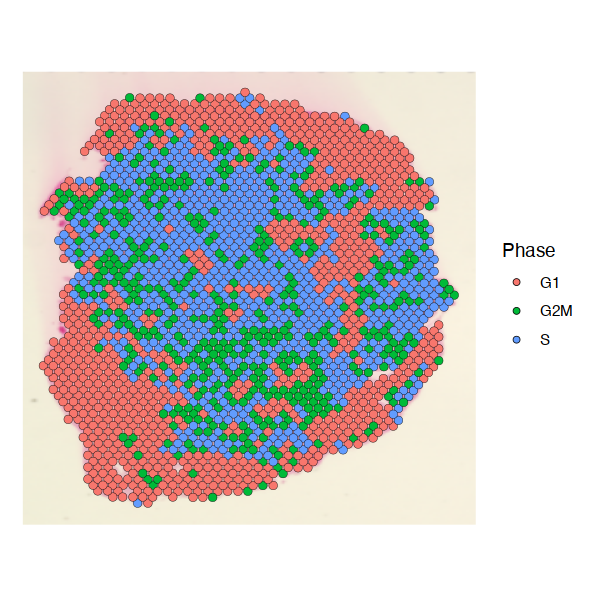

In [70]:
cell_cycle_labels <- as.data.frame(obj_norm[[c("Barcode","seurat_clusters", "Phase")]])

i <- 1
len <- dim(obj_norm[[]])[1]
cell_cycle_coords <- c()

while (i <= len) {
  spot <- obj_norm[[]][i,]
  if (spot[4] %in% cell_cycle_labels$Barcode) {
    label <- cell_cycle_labels[paste0(spot[4]),][3]
  } else {
    label <- "unassigned"
  }
  cell_cycle_coords <- c(cell_cycle_coords, paste0(label)) 
  i <- i+1
}
obj_norm <- AddMetaData(obj_norm,cell_cycle_coords,col.name = "Cell_Phase")

#displays cell phase on spatial plot
phase_palette <-c("#457B9D", "#ED553B", "#F6D55C","gray")

Idents(obj_norm) <- obj_norm$Cell_Phase
col <- phase_palette
col <- head(col, length(unique(Idents(obj_norm))))
names(col) <- unique(Idents(obj_norm))

options(repr.plot.width = 5, repr.plot.height = 5)
SpatialDimPlot(obj_norm, group.by = 'Phase',pt.size=3)

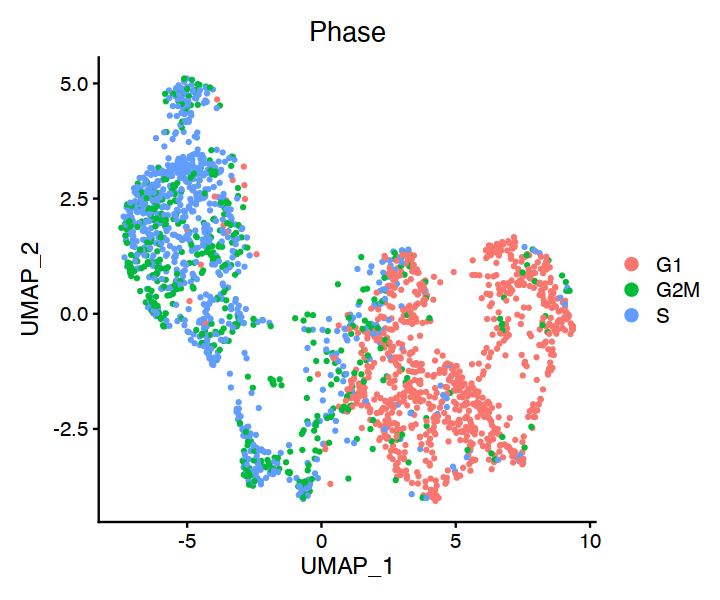

In [71]:
options(repr.plot.width = 6, repr.plot.height = 5)
DimPlot(obj_norm, reduction = "umap", group.by = "Phase")

## Spatially variable features

In [ ]:
#search for features exhibiting spatial patterning in the absence of pre-annotation. The default method (method = 'markvariogram), is inspired by the Trendsceek, which models spatial transcriptomics data as a mark point process and computes a ‘variogram’, which identifies genes whose expression level is dependent on their spatial location. More specifically, this process calculates gamma(r) values measuring the dependence between two spots a certain “r” distance apart. By default, we use an r-value of ‘5’ in these analyses, and only compute these values for variable genes (where variation is calculated independently of spatial location) to save time.
obj_norm <- FindSpatiallyVariableFeatures(obj_norm, assay = "SCT", 
                                          features = VariableFeatures(obj_norm)[1:1000],
                                          selection.method = "moransi")

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


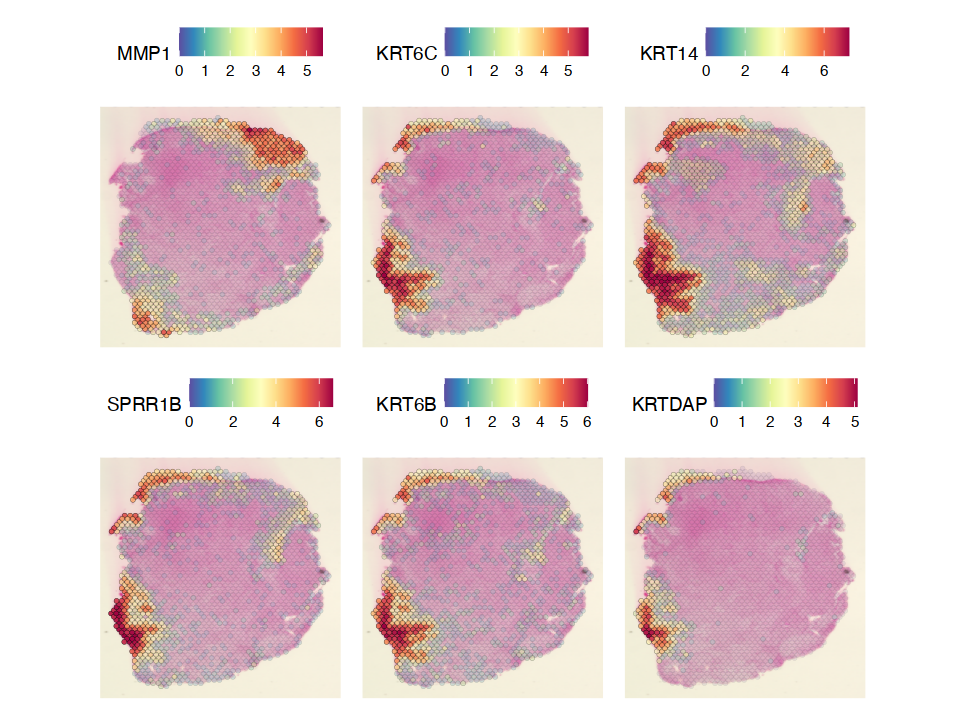

In [77]:
top.features <- head(SpatiallyVariableFeatures(obj_norm, selection.method = "moransi"), 6)
SpatialFeaturePlot(obj_norm, features = top.features, ncol = 3, alpha = c(0.1, 1),pt.size=3)

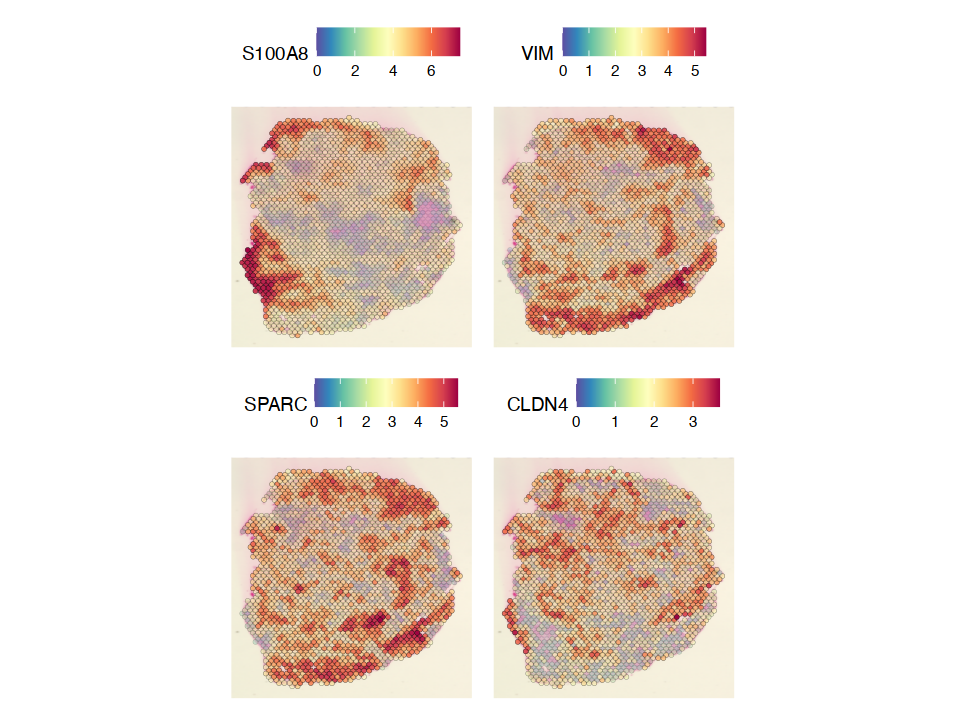

In [74]:
options(repr.plot.width = 8, repr.plot.height = 6)
SpatialFeaturePlot(obj_norm, features = c("S100A8","VIM","SPARC","CLDN4"), ncol = 2, alpha = c(0.1, 1),pt.size=3)

In [75]:
obj_norm

An object of class Seurat 
36093 features across 2204 samples within 2 assays 
Active assay: SCT (18046 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: Spatial
 2 dimensional reductions calculated: pca, umap
 1 image present: tumor

In [76]:
saveRDS(obj_norm,"19h1257-1_PP_preprocessed.rds")